# Tobig's 14기 2주차 Optimization 과제

## Gradient Descent 구현하기
    1) 빈 칸을 채워 함수 완성하기
    2) 강의 내용과 코드에 대해 공부한 내용 적기

    우선 기본적인 설정과 데이터를 불러서 확인한다.

In [48]:
import pandas as pd
import numpy as np
import random

In [49]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Label       200 non-null    int64  
 1   bias        200 non-null    int64  
 2   experience  200 non-null    float64
 3   salary      200 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 6.4 KB


## Train Test 데이터 나누기
    아래의 과정을 통해 데이터셋을 train/test로 나눈다.

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:],data.iloc[:,0], test_size = 0.25, random_state = 0)

    위의 train_test_split 함수를 사용하면 train과 test로 데이터셋을 나눌 수 있다. 순서대로 X데이터와 y데이터를 분할 해주고, test로 사용할 데이터 비율을 설정한다. 마지막으로 random_state를 설정하여 무작위 추출법을 선택해준다. 데이터 수를 아래와 같이 확인해보면 비율에 맞춰 나눠진 것을 확인할 수 있다.

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

    experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춘다. StandardScaler는 평균을 0, 분산을 1로 맞춰주는 scaler이다. X_train에 fit과 transform을 시킨다. 하지만 X_test에는 scaler를 transform만 시킨다. 이미 X_train에 fit했기 때문이다.

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


In [55]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [56]:
# parameter 개수
N = len(X_train.loc[0])

In [57]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
parameters

array([0.01342451, 0.75749943, 0.81042703])

## Logistic Function

## $p = 1/(1+e^{-\beta*X})$

In [58]:
def logistic(X,parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i]*parameters[i]
    p = 1/(1 + np.exp(-z))
    
    return p

In [59]:
logistic(X_train.iloc[1], parameters)

0.7205356089874139

## Object Function

Object Function: 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수이다. 로지스틱 회귀의 목적함수는 Cross entropy loss 함수로 이를 최소화 하는 것이 목적이다.

    cross_entropy_i 함수는 하나의 행에 대해서만 구해진 결과이다. 전체 데이터셋에 대한 loss를 구하기 위해서는 cross_entropy를 사용해야한다. cross_entropy에서도 logistic 함수를 사용해서 p를 대체해도 된다.

In [60]:
def cross_entropy_i(X, y, parameters):
    p = logistic(X,parameters)
    loss = (y*np.log(p)+(1-y)*np.log(1-p))
    return -loss

In [61]:
def cross_entropy(X_set, y_set, parameters) :
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += cross_entropy_i(X,y,parameters)
    return loss

In [62]:
cross_entropy(X_train, y_train, parameters)

136.46912287791267

## Gradient of Cross Entropy

## ${\partial\over{\partial \theta_j}}l(p)= -\sum(y_{i}-p_{i})x_{ij}$


In [63]:
def get_gradient_ij_cross_entropy(X, y, parameters, j):
    p = logistic(X,parameters)
    gradient = (y-p)*X[j]
    return -gradient

In [64]:
get_gradient_ij_cross_entropy(X_train.iloc[0, :], y_train.iloc[0], parameters, 1)

-0.1284628001501548

## Batch Gradient Descent

Batch Gradient Descent: 한 번의 학습으로 모든 데이터셋에 대한 기울기를 구하는 방법이다. 확실히 모수를 정확하게 추측할 수 있지만, 전체 데이터를 다뤄야 하기 때문에 시간이 오래걸린다는 단점이 있다.

In [65]:
def get_gradients_bgd(X_train, y_train, parameters):
    gradients = [0 for i in range(len(parameters))]
    
    for i in range(len(X_train)):
        X = X_train.iloc[i, :]
        y = y_train.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij_cross_entropy(X,y,parameters,j)
            
    return gradients

In [66]:
gradients_bgd = get_gradients_bgd(X_train,y_train,parameters)
gradients_bgd

[32.42931465880591, 20.793944764729, 52.032738948244905]

## Stochastic Gradient Descent

Stochastic Gradient Descent: 한 번의 학습에 임의의 데이터를 선택하여 이에 대한 기울기만을 구한다. 장점으로는 시간이 확실히 짧게 걸리지만 정확성이 많이 떨어진다는 단점이 있다. 임의 추출한 데이터가 이상치거나 좋지 않다면 큰 오류에 빠질 가능성이 크다.

위의 batch gradients descent는 전체를 다루기 때문에 전체 열을 다 지정해준다. 하지만 아래의 Stochastic Gradient Descent는 임의의 데이터를 뽑아야 하기 때문에 random.random()를 통해 0부터 1사이의 난수를 설정한다. 그리고 이를 전체 데이터 갯수에 더하여 임의의 정수를 설정하고 이를 각 데이터셋에 인덱싱하여 gradient를 구한다.

In [67]:
def get_gradients_sgd(X_train, y, parameters):
    gradients = [0 for i in range(len(parameters))]
    r = int(random.random()*len(X_train))
    X = X_train.iloc[r,:]
    y = y_train.iloc[r]
    
    for j in range(len(parameters)):
        gradients[j] = get_gradient_ij_cross_entropy(X,y,parameters,j)
    
    return gradients

In [68]:
gradients_sgd = get_gradients_sgd(X_train, y_train, parameters)
gradients_sgd

[0.28045589646563346, -0.36700464355056905, 0.012332885764594723]

## Update Parameters

gradient를 구한 뒤, 이를 parameters에 반영하여 새로운 parameters를 구하는 함수를 짜준다.

In [69]:
def update_parameters(parameters, gradients, learning_rate) :
    for i in range(len(parameters)):
        gradients[i] *= learning_rate
    parameters -= gradients
    return parameters

In [70]:
update_parameters(parameters, gradients_bgd, 0.01)

array([-0.31086864,  0.54955998,  0.29009964])

## Gradient Descent

learning_rate = 학습률로 다음 실행을 할 때, 이동하는 거리의 크기를 의미한다. 보폭으로 생각하면 쉽게 이해할 수 있다.  
max_iter = 아래 함수를 최대 반복하는 횟수를 정한 것이다.  
tolerance = 허용 오차에 대한 값으로 loss의 차이가 이 값보다 작아진다면 더 이상의 학습은 무의미하다고 판단해도 된다.

In [71]:
def gradient_descent(X_train, y_train, learning_rate=0.01, max_iter=100000, tolerance=0.0001, optimizer="bgd"):
    count = 1
    point = 100 if optimizer == "bgd" else 10000
    N = len(X_train.iloc[0])
    parameters = np.array([random.random() for i in range(N)])
    gradients = [0 for i in range(N)]
    loss = cross_entropy(X_train,y_train,parameters)
    
    while count < max_iter :
        
        if optimizer == "bgd" :
            gradients = get_gradients_bgd(X_train,y_train,parameters)
        elif optimizer == "sgd" :
            gradients = get_gradients_sgd(X_train,y_train,parameters)
        
        if count%point == 0 :
            new_loss = cross_entropy(X_train,y_train,parameters)
            print(count, "loss: ", new_loss, "params: ", parameters, "gradients :", gradients)
            
            if abs(new_loss-loss) < tolerance*len(y_train) :
                break
            loss = new_loss
        
        parameters = update_parameters(parameters, gradients, learning_rate)
        count += 1
    return parameters

In [72]:
new_param_bgd = gradient_descent(X_train, y_train)
new_param_bgd

100 loss:  45.37226786927311 params:  [-1.62586594  3.48089692 -3.30677472] gradients : [0.27434673418587807, -0.9025996746890962, 0.8435794398989779]
200 loss:  44.79947350748002 params:  [-1.78253636  3.99294022 -3.78281256] gradients : [0.0827635638639195, -0.2689333526120898, 0.24870473971619977]
300 loss:  44.74012132128334 params:  [-1.83428801  4.16084338 -3.93783321] gradients : [0.029813191495298985, -0.09657911494329788, 0.08902179690820157]
400 loss:  44.73210817180596 params:  [-1.85344016  4.22285387 -3.99495774] gradients : [0.011334491169068095, -0.036679252831533275, 0.033768960604028904]


array([-1.85344016,  4.22285387, -3.99495774])

## Hyper Parameter Tuning

Hyper Parameter들을 다르게 해서 학습하면 다른 값이 나온다는 것을 확인할 수 있다. 위와 아래의 차이는 단순히 bgd 방법이냐 sgd방법이냐 뿐이다. 나온 parameter 결과값은 매우 유사하나 근소하게 차이를 보이고 있다는 것을 알 수 있다. 

In [73]:
new_param_sgd = gradient_descent(X_train,y_train,learning_rate=0.01,max_iter=100000, tolerance=0.0001, optimizer="sgd")
new_param_sgd

10000 loss:  46.748563585552866 params:  [-1.61139766  3.04237471 -2.80497528] gradients : [0.05629369733911125, -0.08168909985130467, -0.06436255193696788]
20000 loss:  45.17711796228033 params:  [-1.67072425  3.60457323 -3.51753641] gradients : [0.0001691675927710734, -0.0001912348703587342, 0.00014134189310041124]
30000 loss:  44.94748673485817 params:  [-1.87107234  3.89042091 -3.76034086] gradients : [0.18752079532641897, -0.15184854995991595, -0.17729154705754796]
40000 loss:  44.85613488539769 params:  [-1.88228526  4.15010281 -3.82592442] gradients : [-0.214793737906392, -0.055664790377436754, 0.1180678792072771]
50000 loss:  44.81915804414755 params:  [-1.74787969  4.24123692 -4.01551577] gradients : [0.020615278977041976, 0.031785938367840744, 0.0444207032471967]
60000 loss:  44.84540498265975 params:  [-1.80753045  4.18144957 -4.07592739] gradients : [0.11608581211380833, -0.060912871259809154, -0.05615287057627504]
70000 loss:  44.735659082082904 params:  [-1.89795132  4.29

array([-1.97545177,  4.31444203, -4.20846053])

아래의 new_param_bgd들은 optimizer를 bgd 방식으로 tolerance나 learning_rate를 다르게 해서 구한 값이다. 우선 아래의 2개는 learning_rate를 0.001과 0.1로 두고 진행한 결과들이다.

learning_rate가 0.001일 때 눈에 띄는 점은 처음 설정했던 학습률보다 학습률이 작아짐에 따라 연산을 훨씬 더 많이해 parameter를 구하는 시간이 오래 걸린다는 점이다. 반면 learning_rate가 0.1일 때 눈에 띄는 점은 이전보다 연산 시간이 확실이 줄었다는 점이다. 

그러나 new_param_bgd1과 new_param_bgd2는 전혀 다른 parameter값을 도출했다. new_param_bgd1의 경우 위에서 구한 parameter와 유사한 값을 도출했다. 게다가 해당 parameter는 위의 parameter보다 좀 더 정교할 것으로 조심스럽게 추측된다. 반면 new_param_bgd2에서 구한 parameter의 경우 위에서 구한 parameter와 차이가 매우 크다. learning_rate가 커짐으로써, 정교한 도출이 불가능 했을 것을 것이다.

In [74]:
new_param_bgd1 = gradient_descent(X_train,y_train,learning_rate=0.001,max_iter=100000, tolerance=0.0001, optimizer="bgd")
new_param_bgd1

100 loss:  64.01506183004118 params:  [-0.9317551   1.06854516 -0.98800202] gradients : [3.206987567394756, -8.342824050825612, 8.375584350326815]
200 loss:  54.82206246225797 params:  [-1.12640563  1.7318601  -1.63963722] gradients : [1.3653671070369882, -5.256164526208162, 5.107696841056792]
300 loss:  50.8927160672398 params:  [-1.24330045  2.17255708 -2.0658685 ] gradients : [1.011652084164729, -3.7000626981681597, 3.5611546419061475]
400 loss:  48.81368818379668 params:  [-1.33327042  2.49430335 -2.37443265] gradients : [0.7986009850878115, -2.7972274100972405, 2.672813280623333]
500 loss:  47.57667056642643 params:  [-1.40520807  2.74309343 -2.61149576] gradients : [0.6465794734279636, -2.2103975374329417, 2.100222465486679]
600 loss:  46.78383613418733 params:  [-1.46401996  2.94266152 -2.80069385] gradients : [0.533850012458394, -1.79910692795566, 1.7017462136560275]
700 loss:  46.249091653096166 params:  [-1.5129618   3.10682679 -2.95569222] gradients : [0.4477976805176331, -1

array([-1.78837488,  4.01190851, -3.80035103])

In [75]:
new_param_bgd2 = gradient_descent(X_train,y_train,learning_rate=0.1,max_iter=100000, tolerance=0.0001, optimizer="bgd")
new_param_bgd2

100 loss:  54.49240770871232 params:  [-2.21396901  4.49424959 -5.59684438] gradients : [1.221938005260047, -11.823787992571697, -13.060305783230227]
200 loss:  54.52384907027382 params:  [-2.21446701  4.49340886 -5.59853543] gradients : [1.2242236359004415, -11.844699616062492, -13.078572538779918]
300 loss:  54.52388542842257 params:  [-2.21446677  4.4934055  -5.59853515] gradients : [1.2242281047293968, -11.844730678459449, -13.078597203595692]


array([-2.21446677,  4.4934055 , -5.59853515])

아래의 2개는 tolerance 값을 다르게 해서 구한 값들이다. tolerance를 각각 0.001과 0.00001로 두고 학습을 진행했다. 결과는 아래와 같다.

tolerance를 달리 했을 때, 가장 먼저 눈에 들어오는 것은 연산 횟수이다. tolerance가 0.001일 때는 연산 횟수가 줄었다. 반면 tolerance가 0.00001일 때는 연산 횟수가 늘어났다.

또한 new_param_bgd3 - new_param_bgd - new_param_bgd4 순으로 첫 번째 parameter와 세 번째 parameter는 점점 작아지고, 두 번째 parameter는 점점 커짐을 알 수 있다. 이는 tolerance의 변화로 인해 발생하는 것으로 판단할 수 있다.

In [76]:
new_param_bgd3 = gradient_descent(X_train,y_train,learning_rate=0.01,max_iter=100000, tolerance=0.001, optimizer="bgd")
new_param_bgd3

100 loss:  45.38421021680113 params:  [-1.62383166  3.47420253 -3.30051702] gradients : [0.27718750562929056, -0.9121344319121912, 0.8526127348348397]
200 loss:  44.800520440058484 params:  [-1.78192444  3.99095173 -3.78097355] gradients : [0.08341729907921945, -0.27106803739690244, 0.25068875305077876]
300 loss:  44.74025583724082 params:  [-1.83406775  4.16012985 -3.9371755 ] gradients : [0.03002909554773979, -0.09727972950593751, 0.08966882118423665]


array([-1.83406775,  4.16012985, -3.9371755 ])

In [77]:
new_param_bgd4 = gradient_descent(X_train,y_train,learning_rate=0.01,max_iter=100000, tolerance=0.00001, optimizer="bgd")
new_param_bgd4

100 loss:  45.38682629890534 params:  [-1.62338896  3.47274549 -3.2991549 ] gradients : [0.27780704210020407, -0.914214463172494, 0.8545836631741213]
200 loss:  44.80074904162993 params:  [-1.78179147  3.99051962 -3.78057392] gradients : [0.08355944316448567, -0.27153221219716994, 0.25112018494922733]
300 loss:  44.74028518464761 params:  [-1.83401991  4.15997486 -3.93703264] gradients : [0.030076002769462373, -0.09743194702066492, 0.0898093978313852]
400 loss:  44.732131774199594 params:  [-1.85333826  4.22252411 -3.99465415] gradients : [0.011431283611858564, -0.036992683263876086, 0.03405773601107258]
500 loss:  44.73093690689457 params:  [-1.86075236  4.24651209 -4.01673397] gradients : [0.004430467472657393, -0.014331718309012809, 0.013188645980435579]


array([-1.86075236,  4.24651209, -4.01673397])

## 데이터 적합 및 모델 평가

최종적으로 만든 gradient_descent함수에 train 데이터를 적용한다. 이후 test 데이터와 새롭게 얻은 parameter들로 y_predict 값을 구한다. 구한 y_predict 값과 y_test값을 바탕으로 모델을 평가한다. 평가방법은 회귀분석 시간에 사용했던 평가지표를 활용한다. 우선 y_predict 값을 구한다.

In [78]:
new_param_bgd = gradient_descent(X_train, y_train)
new_param_bgd

100 loss:  45.35081024751799 params:  [-1.6295776   3.49310766 -3.31818662] gradients : [0.2691891195636057, -0.8853005136100661, 0.827195737384705]
200 loss:  44.79757830884621 params:  [-1.78365673  3.99658073 -3.7861792 ] gradients : [0.0815683774464118, -0.2650310672098955, 0.2450782731790454]
300 loss:  44.73987733967241 params:  [-1.83469165  4.16215097 -3.93903848] gradients : [0.029417730749418766, -0.0952958790086214, 0.0878367615295439]
400 loss:  44.73207300410715 params:  [-1.85359363  4.2233505  -3.99541496] gradients : [0.011188744268236323, -0.03620730601412034, 0.03333414480542455]


array([-1.85359363,  4.2233505 , -3.99541496])

In [79]:
y_predict=[]
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:],new_param_bgd)
    if p>0.5:
        y_predict.append(1)
    else:
        y_predict.append(0)

In [80]:
from sklearn.metrics import*
tn,fp,fn,tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test,y_predict)

array([[38,  2],
       [ 1,  9]], dtype=int64)

   위에서 만든 y_predict 값과 y_test 값을 바탕으로 confusion matrix를 만든다. 만들어진 matrix는 위와 같다.

In [81]:
accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)

In [82]:
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1_score: ", f1_score)

accuracy:  0.94
precision:  0.8181818181818182
recall:  0.9
f1_score:  0.8571428571428572


만들어진 confusion matrix를 바탕으로 모델 평가에 사용될 accuracy, precision, recall, f1_score 값은 위와 같다. accuracy는 0.94, precision은 약 0.82, recall은 0.9, f1_score는 약 0.86로 모델 성능은 꽤 높은 것으로 판단할 수 있다.

이렇게 직접 계산해도 좋지만, 아래와 같이 코드를 입력하면 한눈에 보기 쉽게 만들 수 있으며 더 많은 정보를 얻을 수 있다. 모델 성능으로 평가하는 지표의 결과값은 직접 계산한 값과 동일하다.

In [83]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.82      0.90      0.86        10

    accuracy                           0.94        50
   macro avg       0.90      0.93      0.91        50
weighted avg       0.94      0.94      0.94        50



Roc curve와 auc의 경우, 모델의 성능을 파악하는데 중요한 지표 중 하나이다. 지표의 값과 그래프를 그리기 위해선 아래와 같은 과정이 필요하다. 

앞서 만들었던 y_predict는 최종 예측값으로 0과 1로만 그 결과가 도출된다. 반면 아래의 y_pred는 0이 될 확률값과 1이 될 확률값을 도출해준다.

In [84]:
y_pred=[]
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:],new_param_bgd)
    y_pred.append([(1-p),p])

In [85]:
y_pred = np.array(y_pred)

In [86]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc = metrics.auc(fpr, tpr)

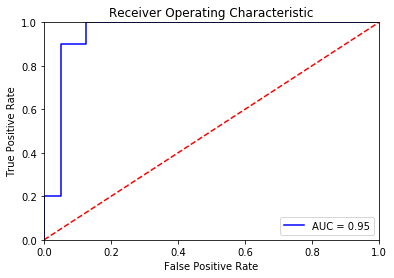

In [87]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#https://www.it-swarm.dev/ko/python/python%EC%97%90%EC%84%9C-roc-%EA%B3%A1%EC%84%A0%EC%9D%84-%EA%B7%B8%EB%A6%AC%EB%8A%94-%EB%B0%A9%EB%B2%95/1048726952/

위의 과정을 통해 만들어진 roc curve는 위와 같고, 이 때 auc 값은 0.95로 나왔다. auc의 경우, 1에 가까울수록 모델의 성능이 좋다는 것을 의미한다. 만들어진 모델은 굉장히 성능이 좋은 것으로 조심스럽게 판단할 수 있다.